In [11]:
class IsingModel:
    def __init__(self, size, temperature, coupling_strength):
        self.size = size
        self.temperature = temperature
        self.coupling_strength = coupling_strength
        self.lattice = np.random.choice([-1, 1], size=(size, size))
        self.total_moves = 0
        self.accepted_moves = 0

    def energy(self):
        return -self.coupling_strength * np.sum(
            self.lattice * (np.roll(self.lattice, 1, axis=0) + np.roll(self.lattice, 1, axis=1))
        )

    def propose_flip(self):
        x, y = np.random.randint(0, self.size, 2)
        return x, y, 2 * self.coupling_strength * self.lattice[x, y] * (
            self.lattice[(x + 1) % self.size, y]
            + self.lattice[(x - 1) % self.size, y]
            + self.lattice[x, (y + 1) % self.size]
            + self.lattice[x, (y - 1) % self.size]
        )

    def gibbs_sampling_step(self):
        x, y = np.random.randint(0, self.size, 2)
        self.total_moves += 1
        neighbors = (
            self.lattice[(x + 1) % self.size, y]
            + self.lattice[(x - 1) % self.size, y]
            + self.lattice[x, (y + 1) % self.size]
            + self.lattice[x, (y - 1) % self.size]
        )
        p = 1 / (1 + np.exp(-2 * self.coupling_strength * neighbors / self.temperature))
        self.lattice[x, y] = np.random.choice([1, -1], p=[p, 1 - p])

    def metropolis_step(self):
        x, y, delta_E = self.propose_flip()
        self.total_moves += 1
        if delta_E < 0 or np.random.random() < np.exp(-delta_E / self.temperature):
            self.lattice[x, y] *= -1
            self.accepted_moves += 1

    def get_acceptance_rate(self):
        return self.accepted_moves / self.total_moves


In [12]:
import matplotlib.pyplot as plt

# Initialize the Ising model
model = IsingModel(50, 10.0, 0.1)
num_MC = 10000

# Run direct sampling steps and plot energy trace
for _ in range(num_MC):
    model.gibbs_sampling_step()
plt.plot(model.energies, label='Gibbs Sampling: Acceptance Rate = {:.2f}'.format(model.get_acceptance_rate()))

# Reset the model and run Metropolis-Hastings steps
model = IsingModel(50, 10.0, 0.1)
for _ in range(num_MC):
    model.metropolis_step()
plt.plot(model.energies, label='Metropolis-Hastings: Acceptance Rate = {:.2f}'.format(model.get_acceptance_rate()))

# Set up the title, legend, and labels
plt.title('Ising Model Energy Trace')
plt.xlabel('Step')
plt.ylabel('Energy')
plt.legend()

plt.show()


AttributeError: 'IsingModel' object has no attribute 'energies'

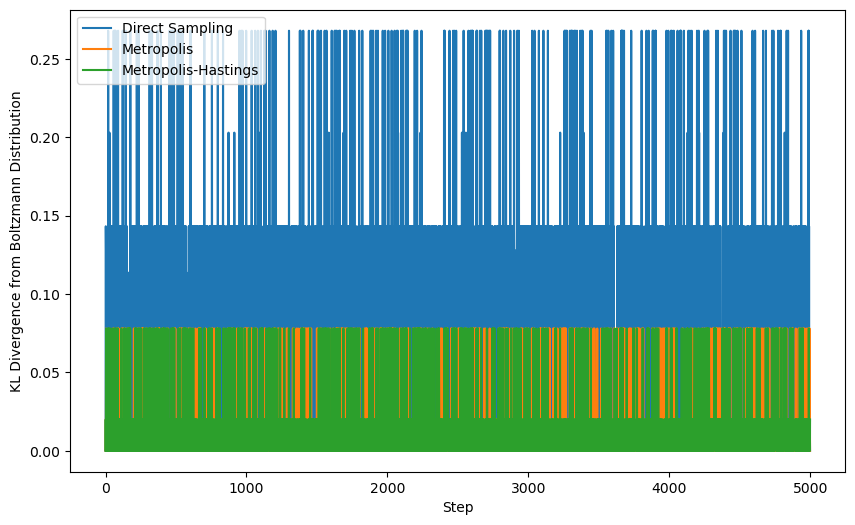

In [15]:
import numpy as np
from scipy.stats import entropy
from matplotlib import pyplot as plt

class IsingModel:
    def __init__(self, size, temperature):
        self.size = size
        self.temperature = temperature
        self.lattice = np.random.choice([-1, 1], size=(size, size))
        self.energies = [self.energy()]
        self.total_moves = 0
        self.accepted_moves = 0

    def energy(self):
        return -np.sum(self.lattice * (np.roll(self.lattice, 1, axis=0) + np.roll(self.lattice, 1, axis=1)))

    def propose_flip(self):
        x, y = np.random.randint(0, self.size, 2)
        return x, y, 2 * self.lattice[x, y] * (self.lattice[(x+1)%self.size, y] + self.lattice[(x-1)%self.size, y] + self.lattice[x, (y+1)%self.size] + self.lattice[x, (y-1)%self.size])

    def direct_sampling_step(self):
        x, y, delta_E = self.propose_flip()
        self.total_moves += 1
        if np.random.random() < np.exp(-delta_E / self.temperature):
            self.lattice[x, y] *= -1
            self.accepted_moves += 1
        self.energies.append(self.energy())

    def metropolis_step(self):
        x, y, delta_E = self.propose_flip()
        self.total_moves += 1
        if delta_E < 0 or np.random.random() < np.exp(-delta_E / self.temperature):
            self.lattice[x, y] *= -1
            self.accepted_moves += 1
        self.energies.append(self.energy())

    def metropolis_hastings_step(self):
        x, y, delta_E = self.propose_flip()
        self.total_moves += 1
        if np.random.random() < min(1, np.exp(-delta_E / self.temperature)):
            self.lattice[x, y] *= -1
            self.accepted_moves += 1
        self.energies.append(self.energy())

    def get_acceptance_rate(self):
        return self.accepted_moves / self.total_moves

# Run the simulations and compute KL divergence
size = 20
temperature = 10.0
num_steps = 5000
ising_model = IsingModel(size, temperature)
kl_divergences = {'Direct': [], 'Metropolis': [], 'Metropolis-Hastings': []}
energy = {'Direct': [], 'Metropolis': [], 'Metropolis-Hastings': []}


for i in range(num_steps):
    ising_model.direct_sampling_step()
    energies, counts = np.unique(ising_model.energies, return_counts=True)
    p = counts / np.sum(counts)
    q = np.exp(-energies / temperature)  # Theoretical Boltzmann distribution
    q /= np.sum(q)
    kl_divergences['Direct'].append(entropy(p, q))

    ising_model = IsingModel(size, temperature)  # reset the model
    ising_model.metropolis_step()
    energies, counts = np.unique(ising_model.energies, return_counts=True)
    p = counts / np.sum(counts)
    q = np.exp(-energies / temperature)  # Theoretical Boltzmann distribution
    q /= np.sum(q)
    kl_divergences['Metropolis'].append(entropy(p, q))

    ising_model = IsingModel(size, temperature)  # reset the model
    ising_model.metropolis_hastings_step()
    energies, counts = np.unique(ising_model.energies, return_counts=True)
    p = counts / np.sum(counts)
    q = np.exp(-energies / temperature)  # Theoretical Boltzmann distribution
    q /= np.sum(q)
    kl_divergences['Metropolis-Hastings'].append(entropy(p, q))

# Plot KL divergence
plt.figure(figsize=(10, 6))
plt.plot(kl_divergences['Direct'], label='Direct Sampling')
plt.plot(kl_divergences['Metropolis'], label='Metropolis')
plt.plot(kl_divergences['Metropolis-Hastings'], label='Metropolis-Hastings')
plt.xlabel('Step')
plt.ylabel('KL Divergence from Boltzmann Distribution')
plt.legend()
plt.show()
